In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpyro.distributions as dist
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm 

CLASSICAL MCMC ALGORITHM

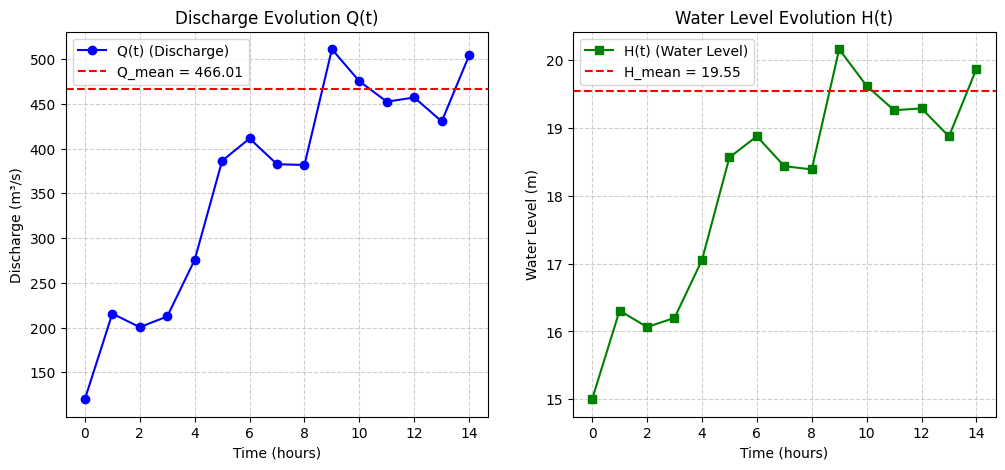

In [ ]:
# 🔹 Model parameters
beta_Q = 5.2    # Rainfall (mm) -> Discharge (m³/s) conversion factor
beta_H = 0.014  # Discharge (m³/s) -> Water level (m) conversion factor
alpha_Q = 0.07  # Drainage coefficient for discharge
alpha_H = 0.002 # Drainage coefficient for water level

# 🔹 Input data
T = 15  # Number of time steps (hours)
time_hours = np.arange(T)  # Explicitly define time steps in hours
R_prev = np.array([10, 20, 0, 5, 15, 25, 10, 0, 5, 30, 0, 2, 7, 1, 20])  # Forecasted rainfall (mm)
Q_obs = 120  # Initial discharge (m³/s)
H_obs = 15   # Initial water level (m)
umbral_Q = 455  # Flooding threshold for discharge (m³/s)
umbral_H = 20   # Flooding threshold for water level (m)

# 🔹 Bayesian flood model
def flood_model(R_prev, Q_obs, H_obs):
    """
    Simulates the evolution of discharge (Q) and water level (H) over time (in hours),
    given historical rainfall data. Uses a dynamic Bayesian approach.

    Parameters:
    - R_prev: Array of previous rainfall values (mm).
    - Q_obs: Initial observed discharge (m³/s).
    - H_obs: Initial observed water level (m).

    Outputs:
    - Plots the evolution of Q(t) and H(t) over time in hours.
    """

    # Initialize arrays for discharge (Q) and water level (H) evolution
    Q_t = jnp.zeros(T)
    H_t = jnp.zeros(T)
    
    # Set initial conditions
    Q_t = Q_t.at[0].set(Q_obs)
    H_t = H_t.at[0].set(H_obs)

    # Time-step simulation using a simple water balance model
    for t in range(1, T):
        rainfall = R_prev[t]  # Rainfall at time step t (hourly)
        # Update discharge: previous discharge + rainfall effect - drainage loss
        Q_t = Q_t.at[t].set(Q_t[t-1] + beta_Q * rainfall - alpha_Q * Q_t[t-1])
        # Update water level: previous level + effect of discharge change - drainage loss
        H_t = H_t.at[t].set(H_t[t-1] + beta_H * (Q_t[t] - Q_t[t-1]) - alpha_H * H_t[t-1])

    # 🔹 Compute dynamic variance based on data dispersion
    Q_mean = 0.7 * jnp.max(Q_t) + 0.3 * jnp.mean(Q_t)  # Weighted mean for Q
    H_mean = 0.7 * jnp.max(H_t) + 0.3 * jnp.mean(H_t)  # Weighted mean for H
    sigma_Q = jnp.maximum(5, 0.1 * jnp.std(Q_t))  # Ensuring minimum variance for Q
    sigma_H = jnp.maximum(0.5, 0.05 * jnp.std(H_t))  # Ensuring minimum variance for H

    # 🔹 Visualization of discharge and water level evolution
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot discharge evolution
    ax[0].plot(time_hours, Q_t, marker='o', color='b', linestyle='-', label='Q(t) (Discharge)')
    ax[0].axhline(Q_mean, color='r', linestyle='--', label=f'Q_mean = {Q_mean:.2f}')
    ax[0].set_title("Discharge Evolution Q(t)")
    ax[0].set_xlabel("Time (hours)")  # Updated to hours
    ax[0].set_ylabel("Discharge (m³/s)")
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.6)

    # Plot water level evolution
    ax[1].plot(time_hours, H_t, marker='s', color='g', linestyle='-', label='H(t) (Water Level)')
    ax[1].axhline(H_mean, color='r', linestyle='--', label=f'H_mean = {H_mean:.2f}')
    ax[1].set_title("Water Level Evolution H(t)")
    ax[1].set_xlabel("Time (hours)")  # Updated to hours
    ax[1].set_ylabel("Water Level (m)")
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.6)

    # Show the plots
    plt.savefig('./results/predictions.png', dpi=300, bbox_inches="tight")
    plt.show()

# Run the flood model simulation
flood_model(R_prev, Q_obs, H_obs)


In [3]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2851.19it/s, 7 steps of size 6.76e-01. acc. prob=0.93]


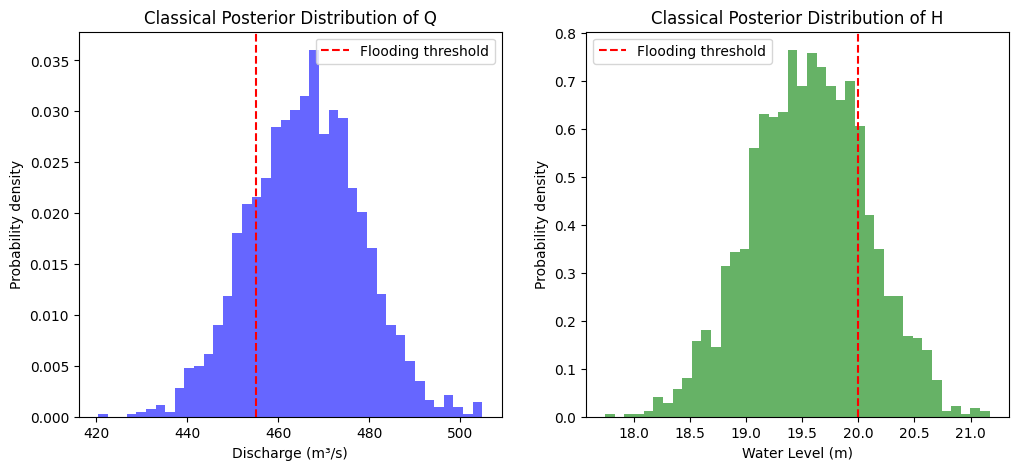

📌 Probability of extreme discharge P(Q > 455): 0.7401
📌 Probability of extreme water level P(H > 20): 0.2702


In [ ]:
# 🔹 Model parameters
beta_Q = 5.2    # Rainfall (mm) -> Discharge (m³/s) conversion factor
beta_H = 0.014  # Discharge (m³/s) -> Water level (m) conversion factor
alpha_Q = 0.07  # Drainage coefficient for discharge
alpha_H = 0.002 # Drainage coefficient for water level

# 🔹 Input data
T = 15  # Number of time steps (hours)
time_hours = np.arange(T)  # Explicitly define time steps in hours
R_prev = np.array([10, 20, 0, 5, 15, 25, 10, 0, 5, 30, 0, 2, 7, 1, 20])  # Forecasted rainfall (mm)
Q_obs = 120  # Initial discharge (m³/s)
H_obs = 15   # Initial water level (m)
umbral_Q = 455  # Flooding threshold for discharge (m³/s)
umbral_H = 20   # Flooding threshold for water level (m)

# 🔹 Bayesian flood model
def flood_model(R_prev, Q_obs, H_obs):
    """
    Simulates the evolution of discharge (Q) and water level (H) over time (in hours),
    given historical rainfall data, using a Bayesian approach.

    Parameters:
    - R_prev: Array of previous rainfall values (mm).
    - Q_obs: Initial observed discharge (m³/s).
    - H_obs: Initial observed water level (m).

    Outputs:
    - Returns posterior distributions of Q and H at the final time step.
    """

    # Initialize arrays for discharge (Q) and water level (H)
    Q_t = jnp.zeros(T)
    H_t = jnp.zeros(T)

    # Set initial conditions
    Q_t = Q_t.at[0].set(Q_obs)
    H_t = H_t.at[0].set(H_obs)

    # Time-step simulation using a water balance model
    for t in range(1, T):
        rainfall = R_prev[t]  # Rainfall at time t (in mm)
        # Update discharge: previous discharge + rainfall contribution - drainage loss
        Q_t = Q_t.at[t].set(Q_t[t-1] + beta_Q * rainfall - alpha_Q * Q_t[t-1])
        # Update water level: previous level + change in discharge - drainage loss
        H_t = H_t.at[t].set(H_t[t-1] + beta_H * (Q_t[t] - Q_t[t-1]) - alpha_H * H_t[t-1])

    # 🔹 Compute dynamic variance based on data dispersion
    Q_mean = 0.7 * jnp.max(Q_t) + 0.3 * jnp.mean(Q_t)  # Weighted mean for Q
    H_mean = 0.7 * jnp.max(H_t) + 0.3 * jnp.mean(H_t)  # Weighted mean for H
    sigma_Q = jnp.maximum(5, 0.1 * jnp.std(Q_t))  # Maximum variance threshold for Q
    sigma_H = jnp.maximum(0.5, 0.05 * jnp.std(H_t))  # Maximum variance threshold for H

    # 🔹 Assume a covariance matrix. If Q and H are uncorrelated, covariance = 0.
    cov_QH = 0.5 * sigma_Q * sigma_H  # Adjust this based on the relationship between Q and H
    cov_matrix = jnp.array([[sigma_Q**2, cov_QH], [cov_QH, sigma_H**2]])

    # 🔹 Joint prior distribution for Q_final and H_final (2D Gaussian)
    mean_vector = jnp.array([Q_mean, H_mean])
    normal_bi = numpyro.sample("QH_final", dist.MultivariateNormal(mean_vector, cov_matrix))

    # Extract final values for Q and H
    Q_final, H_final = normal_bi[0], normal_bi[1]

    # 🔹 Compute the probability that discharge and water level exceed thresholds
    prob_Q = numpyro.deterministic("P_Q", 1 - dist.Normal(Q_final, sigma_Q).cdf(umbral_Q))
    prob_H = numpyro.deterministic("P_H", 1 - dist.Normal(H_final, sigma_H).cdf(umbral_H))

# 🔹 MCMC Inference
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(flood_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key, R_prev, Q_obs, H_obs)

# 🔹 Extract posterior samples
posterior_samples = mcmc.get_samples()
Q_final = posterior_samples["QH_final"][:, 0]  # First component (discharge)
H_final = posterior_samples["QH_final"][:, 1]  # Second component (water level)
P_Q_posterior = posterior_samples["P_Q"]  # Probability of Q > threshold
P_H_posterior = posterior_samples["P_H"]  # Probability of H > threshold

# 🔹 Visualizing posterior distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for discharge
ax[0].hist(Q_final, bins=40, density=True, alpha=0.6, color="b")
ax[0].axvline(umbral_Q, color="r", linestyle="--", label="Flooding threshold")
ax[0].set_title("Classical Posterior Distribution of Q")
ax[0].set_xlabel("Discharge (m³/s)")
ax[0].set_ylabel("Probability density")
ax[0].legend()

# Histogram for water level
ax[1].hist(H_final, bins=40, density=True, alpha=0.6, color="g")
ax[1].axvline(umbral_H, color="r", linestyle="--", label="Flooding threshold")
ax[1].set_title("Classical Posterior Distribution of H")
ax[1].set_xlabel("Water Level (m)")
ax[1].set_ylabel("Probability density")
ax[1].legend()

plt.savefig('./results/marginal_classical_MCMC.png', dpi=300, bbox_inches="tight")
plt.show()

# 🔹 Compute joint flooding probability
P_Q = P_Q_posterior  # Sampled probabilities of Q > umbral_Q
P_H = P_H_posterior  # Sampled probabilities of H > umbral_H

# 🔹 Print results
print(f"📌 Probability of extreme discharge P(Q > {umbral_Q}): {jnp.mean(P_Q):.4f}")
print(f"📌 Probability of extreme water level P(H > {umbral_H}): {jnp.mean(P_H):.4f}")


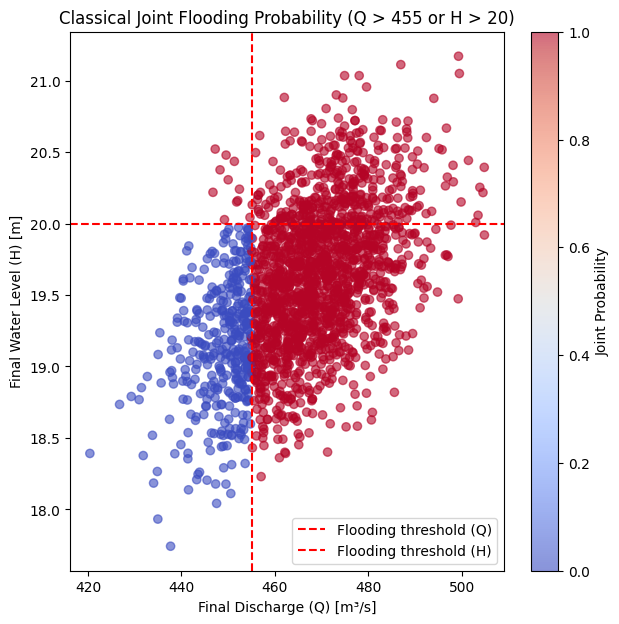

📌 Joint probability of flooding (Q > 455 or H > 20): 0.8145


In [ ]:
# 🔹 Compute the joint probability that either Q > threshold_Q or H > threshold_H
P_joint = (P_Q > 0.5) | (P_H > 0.5)  # Joint probability (at least one exceeds the threshold)

# 🔹 Visualize the joint probability as a scatter plot
fig, ax = plt.subplots(figsize=(7, 7))  # Adjusted figure size for better readability

# Scatter plot of Q_final vs H_final with color representing joint probability
scatter = ax.scatter(
    Q_final, H_final, c=P_joint, cmap="coolwarm", alpha=0.6, marker="o"
)

# Add reference threshold lines for flooding
ax.axvline(umbral_Q, color="r", linestyle="--", label="Flooding threshold (Q)")
ax.axhline(umbral_H, color="r", linestyle="--", label="Flooding threshold (H)")

# Axis labels and title
ax.set_xlabel("Final Discharge (Q) [m³/s]")
ax.set_ylabel("Final Water Level (H) [m]")
ax.set_title("Classical Joint Flooding Probability (Q > 455 or H > 20)")

# Add legend
ax.legend()

# Add color bar to visualize probability scale
cbar = fig.colorbar(scatter, ax=ax, label="Joint Probability")

# Show the plot
plt.savefig('./results/joint_classical_MCMC.png', dpi=300, bbox_inches="tight")
plt.show()

# 🔹 Compute and display the mean joint probability of flooding
P_joint_mean = jnp.mean(P_joint)
print(f"📌 Joint probability of flooding (Q > {umbral_Q} or H > {umbral_H}): {P_joint_mean:.4f}")


In [ ]:
import numpy as np

# Define the path to save the data
data_save_path = "./results/QH_classical_data.txt"

# Stack Q_final and H_final into a single array for saving
data_to_save = np.column_stack((Q_final, H_final))

# Save the data as a text file with column headers
np.savetxt(
    data_save_path, data_to_save, fmt="%.4f", delimiter="\t",
    header="Q_final (m³/s)\tH_final (m)", comments=""
)

print(f"📄 Data saved successfully at: {data_save_path}")


📄 Data saved successfully at: /Users/gescrig/pasqal/imagenes/QH_classical_data.txt


QUANTUM ANALOG ALGORITHM

In [7]:
import numpy as np
import numpyro.distributions as dist
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# 🔹 Define bivariate normal distribution parameters
beta_Q, beta_H = 5.2, 0.014  # Rainfall-discharge and discharge-water level coefficients
alpha_Q, alpha_H = 0.07, 0.002  # Discharge and water level drainage coefficients
T = 15  # Number of time steps (hours)
R_prev = np.array([10, 20, 0, 5, 15, 25, 10, 0, 5, 30, 0, 2, 7, 1, 20])  # Previous rainfall data (mm)
Q_obs, H_obs = 120, 15  # Initial discharge (m³/s) and water level (m)
umbral_Q = 455  # Discharge flooding threshold (m³/s)
umbral_H = 20  # Water level flooding threshold (m)

# 🔹 Initialize Q_t (discharge) and H_t (water level) arrays
Q_t = jnp.zeros(T).at[0].set(Q_obs)
H_t = jnp.zeros(T).at[0].set(H_obs)

# 🔹 Simulate the evolution of Q and H over time
for t in range(1, T):
    lluvia = R_prev[t]  # Rainfall at time step t
    # Compute new discharge considering rainfall contribution and drainage
    Q_t = Q_t.at[t].set(Q_t[t-1] + beta_Q * lluvia - alpha_Q * Q_t[t-1])
    # Compute new water level based on discharge variation and drainage
    H_t = H_t.at[t].set(H_t[t-1] + beta_H * (Q_t[t] - Q_t[t-1]) - alpha_H * H_t[t-1])

# 🔹 Compute statistical parameters for bivariate normal distribution
Q_mean = 0.7 * jnp.max(Q_t) + 0.3 * jnp.mean(Q_t)  # Weighted mean for Q
H_mean = 0.7 * jnp.max(H_t) + 0.3 * jnp.mean(H_t)  # Weighted mean for H
sigma_Q = jnp.maximum(5, 0.1 * jnp.std(Q_t))  # Ensure minimum variance for Q
sigma_H = jnp.maximum(0.5, 0.05 * jnp.std(H_t))  # Ensure minimum variance for H
cov_QH = 0.5 * sigma_Q * sigma_H  # Assumed covariance between Q and H
cov_matrix = jnp.array([[sigma_Q**2, cov_QH], [cov_QH, sigma_H**2]])  # Covariance matrix
mean_vector = jnp.array([Q_mean, H_mean])

# 🔹 Define the bivariate normal distribution
normal_bi = dist.MultivariateNormal(mean_vector, cov_matrix)

# 🔹 Function to generate binary mapping between real values (Q, H) and binary strings
def generate_binary_mapping(Q_values, H_values):
    """Maps real values (Q, H) to binary strings for encoding."""
    combinations = [(q, h) for q in Q_values for h in H_values]
    n = len(combinations)
    num_bits = int(np.ceil(np.log2(n)))  # Compute the number of bits required
    bitstrings = [np.binary_repr(i, num_bits) for i in range(n)]
    return {combinations[i]: bitstrings[i] for i in range(n)}

# 🔹 Function to compute probability of (Q, H) given the bivariate normal distribution
def compute_probability(Q_value, H_value, normal_bi):
    """Computes the probability of a (Q, H) pair based on the bivariate normal distribution."""
    value = jnp.array([Q_value, H_value])
    probability = jnp.exp(normal_bi.log_prob(value))  # Convert log-probability to probability
    return float(probability)

# 🔹 Function to estimate QUBO matrix
def estimate_Q(X, f_values):
    """Estimates the QUBO matrix from the dataset using optimization."""
    n = X.shape[1]  # Number of variables
    Q_size = n * (n + 1) // 2  # Size of the upper triangular matrix

    # Define function for QUBO calculation
    def qubo_function(Q_vec, X):
        """Computes QUBO function values given a vectorized Q matrix."""
        Q = np.zeros((n, n))
        idx = np.triu_indices(n)
        Q[idx] = Q_vec
        return np.array([x @ Q @ x for x in X])

    # Define loss function for optimization
    def loss(Q_vec):
        """Loss function to minimize the difference between f(x) and x^T Q x."""
        return qubo_function(Q_vec, X) - f_values

    # Solve the optimization problem
    result = least_squares(loss, np.zeros(Q_size))

    # Reconstruct the Q matrix
    Q = np.zeros((n, n))
    idx = np.triu_indices(n)
    Q[idx] = result.x
    return Q

# 🔹 Function to compute approximate function values using QUBO
def approximate_f(X, Q):
    """Computes the approximated function values using the estimated QUBO matrix."""
    return np.array([x @ Q @ x for x in X])

# 🔹 Function to plot bitstring distributions
def plot_distribution(C, indexes):
    """Plots the distribution of bitstrings with color differentiation."""
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "r" if key in indexes else "g" for key in C}

    plt.figure(figsize=(12, 6))
    plt.xlabel("Bitstrings")
    plt.ylabel("Counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

# 🔹 Function to generate values of Q and H for a given bit depth
def generate_QH_values(num_bits):
    """Generates uniformly distributed random values for Q and H."""
    n = 2 ** num_bits  # Ensure values match the number of binary states
    Q_values = np.random.uniform(440, 500, n)  # Generate Q values in range
    H_values = np.random.uniform(18, 21, n)  # Generate H values in range
    return Q_values, H_values

# 🔹 Function to compute weighted means based on bitstring counts
def compute_weighted_means(counts, q_h_to_bin):
    """Computes the weighted means of Q and H based on bitstring counts."""
    total_counts = sum(counts.values())  # Total occurrences
    sum_Q, sum_H = 0, 0

    for (q, h), bitstring in q_h_to_bin.items():
        if bitstring in counts:
            sum_Q += q * counts[bitstring]
            sum_H += h * counts[bitstring]

    return sum_Q / total_counts, sum_H / total_counts  # Compute weighted averages

# 🔹 Function to reduce the binary representation while maintaining mappings
def reduce_bit_representation(counts, q_h_to_bin, new_num_bits):
    """
    Reduces the binary representation while maintaining the mapping between (Q, H) values and bitstrings.

    :param counts: Dictionary containing frequencies of each bitstring.
    :param q_h_to_bin: Original dictionary mapping (Q, H) to bitstrings.
    :param new_num_bits: New number of bits per parameter.
    :return: New dictionary with reduced-bit representation.
    """
    num_elements = 2 ** (2 * new_num_bits)  # Compute new number of elements
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)  # Sort by frequency
    selected_bitstrings = set(dict(sorted_counts[:num_elements]).keys())  # Select top elements

    # Create new mapping with reduced bit length
    filtered_q_h_to_bin = {k: v for k, v in q_h_to_bin.items() if v in selected_bitstrings}
    new_bitstrings = [np.binary_repr(i, 2 * new_num_bits) for i in range(num_elements)]
    
    return {k: new_bitstrings[i] for i, (k, _) in enumerate(filtered_q_h_to_bin.items())}


In [ ]:
def run_quantum_algorithm(num_bits, Q_estimada):
    """
    Simulates a quantum algorithm to solve the QUBO problem using an adiabatic quantum computing approach.

    Parameters:
    - num_bits (int): The number of bits per parameter (used to determine qubit count).
    - Q_estimada (numpy.ndarray): The estimated QUBO matrix.

    Returns:
    - count_dict (dict): Dictionary containing the sampled final state counts from the quantum emulator.
    """

    # 🔹 Convert the estimated QUBO matrix into a negative form to align with minimization
    Q = -Q_estimada  

    # 🔹 Generate all possible binary bitstrings corresponding to the problem size
    bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
    costs = []  # List to store cost values for each bitstring

    # 🔹 Compute the cost function for each bitstring (this is an exponential operation)
    for b in bitstrings:
        z = np.array(list(b), dtype=int)  # Convert bitstring to binary array
        cost = z.T @ Q @ z  # Compute cost using the QUBO matrix
        costs.append(cost)

    # 🔹 Pair each bitstring with its cost and sort them by increasing cost
    zipped = zip(bitstrings, costs)
    sort_zipped = sorted(zipped, key=lambda x: x[1])  

    # 🔹 Number of qubits (each parameter has num_bits qubits, considering two parameters Q and H)
    num_qubits = 2 * num_bits  

    # 🔹 Generate qubit positions in a circular layout
    angles = np.linspace(0, 2 * np.pi, num_qubits, endpoint=False)  # Evenly distribute qubits
    radii = 24  # Fixed radius to ensure uniform qubit placement

    # 🔹 Convert polar coordinates to Cartesian (x, y) coordinates
    x_coords = radii * np.cos(angles)
    y_coords = radii * np.sin(angles)
    coords = np.column_stack((x_coords, y_coords))  # Stack x and y into coordinate pairs

    # 🔹 Create the qubit register dictionary
    qubits = {f"q{i}": coord for i, coord in enumerate(coords)}

    # 🔹 Initialize the quantum register with qubit coordinates
    reg = Register(qubits)

    # 🔹 Define the adiabatic evolution parameters
    Omega = min(15, np.median(Q[Q > 0].flatten()))  # Select a median control parameter
    delta_0 = -5  # Initial detuning (must be negative)
    delta_f = 0.5  # Final detuning (must be positive)
    T = 8000  # Evolution time in nanoseconds (long enough for system propagation)

    # 🔹 Create the adiabatic pulse for quantum annealing
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),  # Rabi frequency control
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),  # Detuning control
        0,  # Phase of the pulse
    )

    # 🔹 Define the quantum sequence and declare the interaction channel
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")  # Rydberg global interaction
    seq.add(adiabatic_pulse, "ising")  # Add pulse to the system

    # 🔹 Simulate the quantum process using QuTiP emulator
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()

    # 🔹 Retrieve the final quantum state
    final = results.get_final_state()

    # 🔹 Sample the final state to obtain bitstring counts
    count_dict = results.sample_final_state()

    return count_dict  # Return the dictionary of bitstring frequencies


In [ ]:
# 🔹 Define number of repetitions for Monte Carlo simulation
num_repetitions = 1000  # Number of iterations for statistical accuracy
num_bits_max = 2  # Initial number of bits per parameter (Q and H)

# 🔹 Lists to store the mean values of Q (discharge) and H (water level)
mean_Q_list = []
mean_H_list = []

# 🔹 Main simulation loop
for _ in tqdm(range(num_repetitions), desc="Running simulations"):

    # 🔹 Generate random values for Q and H based on the specified number of bits
    Q_values, H_values = generate_QH_values(num_bits_max)

    # 🔹 Create a binary mapping from (Q, H) values to bitstrings
    q_h_to_bin = generate_binary_mapping(Q_values, H_values)

    # 🔹 Construct dataset in the format X (binary inputs) and f_values (objective function)
    X = np.array([list(map(int, q_h_to_bin[(q, h)])) for (q, h) in q_h_to_bin.keys()])
    f_values = 10000 * np.array([compute_probability(q, h, normal_bi) for (q, h) in q_h_to_bin.keys()])

    # 🔹 Estimate the initial QUBO matrix for optimization
    Q_estimada = estimate_Q(X, f_values)

    # 🔹 Iteratively reduce the bit representation in each loop
    for num_bits in range(num_bits_max, 0, -1):
        
        # 🔹 Execute the quantum algorithm to optimize the QUBO problem
        counts = run_quantum_algorithm(num_bits, Q_estimada)

        # 🔹 Reduce bit representation for the next iteration (except for the last step)
        if num_bits > 1:
            q_h_to_bin = reduce_bit_representation(counts, q_h_to_bin, num_bits - 1)  # Reduce to (num_bits - 1)

            # 🔹 Update dataset X and function values f_values with reduced representation
            X = np.array([list(map(int, q_h_to_bin[(q, h)])) for (q, h) in q_h_to_bin.keys()])
            f_values = 10000 * np.array([compute_probability(q, h, normal_bi) for (q, h) in q_h_to_bin.keys()])

            # 🔹 Recalculate the QUBO matrix with the updated dataset
            Q_estimada = estimate_Q(X, f_values)

        # 🔹 Compute the weighted mean values for Q and H at the final iteration
        if num_bits == 1:
            mean_Q, mean_H = compute_weighted_means(counts, q_h_to_bin)

    # 🔹 Store the computed mean values for Q and H after each repetition
    mean_Q_list.append(mean_Q)
    mean_H_list.append(mean_H)

# Convert lists to NumPy arrays for analysis
mean_Q_array = np.array(mean_Q_list)
mean_H_array = np.array(mean_H_list)

# Compute boolean arrays for exceeding thresholds
P_Q_exceed = mean_Q_array > umbral_Q  # Boolean mask for Q > threshold
P_H_exceed = mean_H_array > umbral_H  # Boolean mask for H > threshold

# Compute probabilities of exceeding thresholds
P_Q_prob = np.mean(P_Q_exceed)  # Probability of exceeding discharge threshold
P_H_prob = np.mean(P_H_exceed)  # Probability of exceeding water level threshold

# 🔹 Print results
print(f"📌 Probability of extreme discharge P(Q > {umbral_Q}): {P_Q_prob:.4f}")
print(f"📌 Probability of extreme water level P(H > {umbral_H}): {P_H_prob:.4f}")

Running simulations:   0%|          | 4/1000 [00:01<04:10,  3.97it/s]/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Running simulations: 100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]

Simulation completed.


In [ ]:
# Define the path to save the data
data_save_path = "./results/QH_quantum_data.txt"

# Stack Q_final and H_final into a single array for saving
data_to_save = np.column_stack((mean_Q_array, mean_H_array))

# Save the data as a text file with column headers
np.savetxt(
    data_save_path, data_to_save, fmt="%.4f", delimiter="\t",
    header="Q_final (m³/s)\tH_final (m)", comments=""
)

print(f"📄 Data saved successfully at: {data_save_path}")

📄 Data saved successfully at: /Users/gescrig/pasqal/imagenes/QH_quantum_data.txt


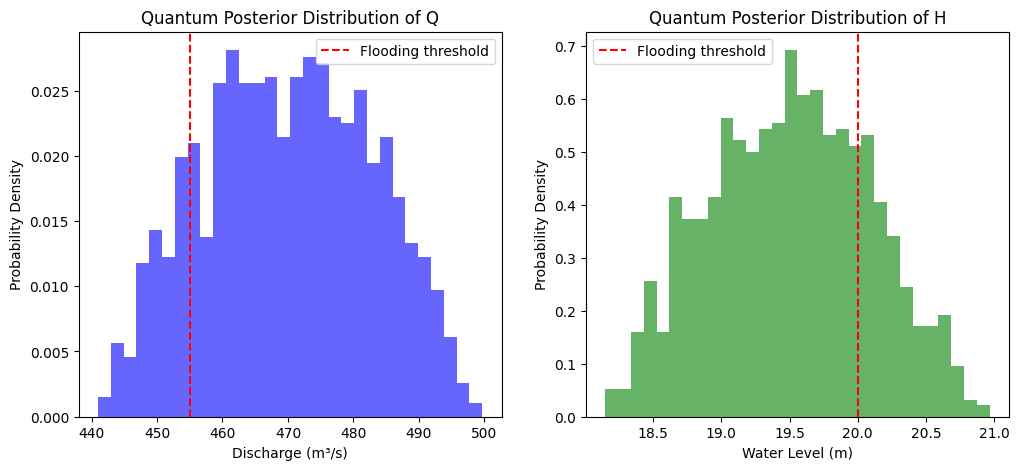

In [ ]:
# 🔹 Create subplots for visualizing the posterior distributions of Q (discharge) and H (water level)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Two plots side by side

# 🔹 Histogram for discharge (Q)
ax[0].hist(mean_Q_array, bins=30, density=True, alpha=0.6, color="b")  # Plot histogram with density normalization
ax[0].axvline(umbral_Q, color="r", linestyle="--", label="Flooding threshold")  # Add threshold line
ax[0].set_title("Quantum Posterior Distribution of Q")  # Set plot title
ax[0].set_xlabel("Discharge (m³/s)")  # X-axis label
ax[0].set_ylabel("Probability Density")  # Y-axis label
ax[0].legend()  # Display legend

# 🔹 Histogram for water level (H)
ax[1].hist(mean_H_array, bins=30, density=True, alpha=0.6, color="g")  # Plot histogram with density normalization
ax[1].axvline(umbral_H, color="r", linestyle="--", label="Flooding threshold")  # Add threshold line
ax[1].set_title("Quantum Posterior Distribution of H")  # Set plot title
ax[1].set_xlabel("Water Level (m)")  # X-axis label
ax[1].set_ylabel("Probability Density")  # Y-axis label
ax[1].legend()  # Display legend

# 🔹 Save the plot as a high-resolution image
plt.savefig('./results/marginal_quantum_MCMC.png', dpi=300, bbox_inches="tight")  

# 🔹 Display the plot
plt.show()

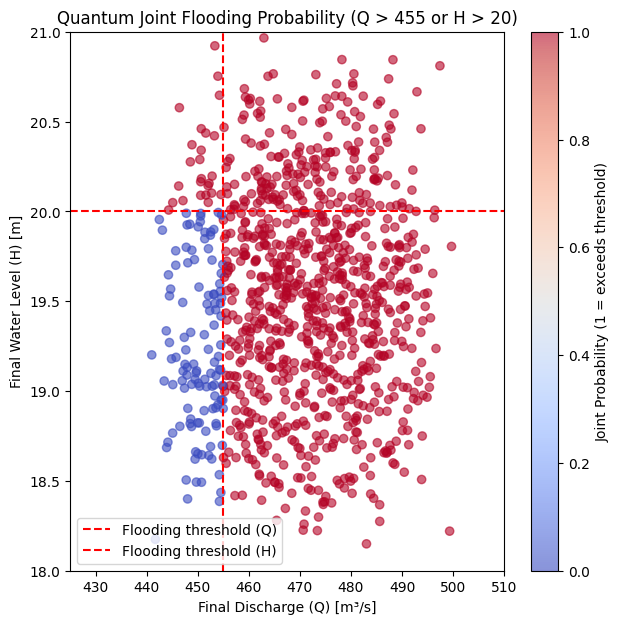

📌 Joint probability of flooding (Q > 455 or H > 20): 0.8820


In [ ]:
# 🔹 Compute the joint probability that either Q > threshold_Q or H > threshold_H
P_joint = (mean_Q_array > umbral_Q) | (mean_H_array > umbral_H)  # Joint probability (at least one exceeds the threshold)

# 🔹 Visualize the joint probability
fig, ax = plt.subplots(figsize=(7, 7))

# Create the scatter plot with colors indicating P_joint (0 or 1)
scatter = ax.scatter(
    mean_Q_array, mean_H_array, c=P_joint, cmap="coolwarm", alpha=0.6, marker="o"
)

# Add reference threshold lines for flooding
ax.axvline(umbral_Q, color="r", linestyle="--", label="Flooding threshold (Q)")
ax.axhline(umbral_H, color="r", linestyle="--", label="Flooding threshold (H)")

# Set axis labels and title
ax.set_xlabel("Final Discharge (Q) [m³/s]")
ax.set_ylabel("Final Water Level (H) [m]")
ax.set_title("Quantum Joint Flooding Probability (Q > 455 or H > 20)")

# 🔹 Adjust x and y axis limits
ax.set_xlim(425, 510)  # 🔹 Set x-axis limits for Q
ax.set_ylim(18, 21)    # 🔹 Set y-axis limits for H

# Add legend
ax.legend()

# Add color bar to visualize probability scale
cbar = plt.colorbar(scatter, ax=ax, label="Joint Probability (1 = exceeds threshold)")

# Show the plot
plt.savefig('./results/joint_quantum_MCMC.png', dpi=300, bbox_inches="tight")
plt.show()

# 🔹 Compute and display the mean joint probability of flooding
P_joint_mean = np.mean(P_joint)
print(f"📌 Joint probability of flooding (Q > {umbral_Q} or H > {umbral_H}): {P_joint_mean:.4f}")

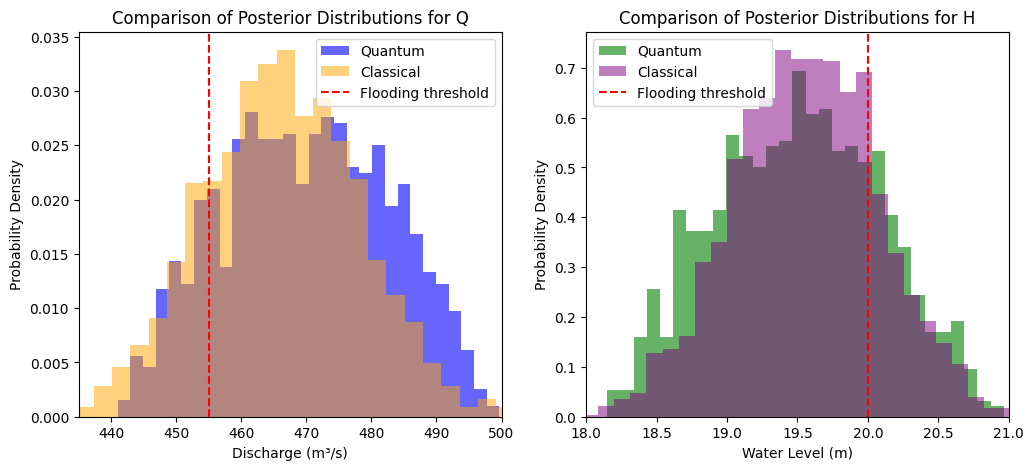

In [ ]:
# 🔹 Define the path to the saved classical data file
data_file_path = "./results/QH_classical_data.txt"

# 🔹 Load the classical Q_final and H_final data from the text file
data_loaded = np.loadtxt(data_file_path, delimiter="\t", skiprows=1)  # Skip header row
Q_final_classical = data_loaded[:, 0]  # First column: Classical Q_final
H_final_classical = data_loaded[:, 1]  # Second column: Classical H_final

# 🔹 Visualizing posterior distributions with quantum vs classical comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 🔹 Histogram for discharge (Q) - Quantum vs Classical
ax[0].hist(mean_Q_array, bins=30, density=True, alpha=0.6, color="b", label="Quantum")
ax[0].hist(Q_final_classical, bins=30, density=True, alpha=0.5, color="orange", label="Classical")
ax[0].axvline(umbral_Q, color="r", linestyle="--", label="Flooding threshold")
ax[0].set_title("Comparison of Posterior Distributions for Q")
ax[0].set_xlabel("Discharge (m³/s)")
ax[0].set_ylabel("Probability Density")
ax[0].set_xlim(435, 500)  # 🔹 Set x-axis limits for Q
ax[0].legend()

# 🔹 Histogram for water level (H) - Quantum vs Classical
ax[1].hist(mean_H_array, bins=30, density=True, alpha=0.6, color="g", label="Quantum")
ax[1].hist(H_final_classical, bins=30, density=True, alpha=0.5, color="purple", label="Classical")
ax[1].axvline(umbral_H, color="r", linestyle="--", label="Flooding threshold")
ax[1].set_title("Comparison of Posterior Distributions for H")
ax[1].set_xlabel("Water Level (m)")
ax[1].set_ylabel("Probability Density")
ax[1].set_xlim(18, 21)  # 🔹 Set x-axis limits for H
ax[1].legend()

# 🔹 Save the overlayed comparison plot
plt.savefig('./results/marginal_comparison_MCMC.png', dpi=300, bbox_inches="tight")
plt.show()